# import

In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [2]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

## inac

In [4]:
data622 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))

In [5]:
data709 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))

In [40]:
data718 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-18\1'))

In [3]:
data425 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [4]:
data621 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-21\1'))

In [5]:
data729 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-29\1'))

## lens

In [6]:
data725 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-25\1'))

In [7]:
data816 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-16\1'))

In [8]:
data822 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-22\1'))

## vis

In [7]:
data819 = wfOpto(Path(r'Y:\Subjects\ZYE_0087\2024-08-19\1'))

In [10]:
data822Vis = wfOpto(Path(r'Y:\Subjects\AL_0035\2024-08-22\1'))

In [11]:
data904 = wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-04\1'))

In [12]:
data910 = wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-10\1'))

# funcs

### brain

In [175]:
def brainImg(ax,data,frame,galvoX=0,galvoY=0,power=2,n_samples=100,start=-.3,end=1,X=150,Y=350,normset=0,colorbarlabel='Brin Activity dF/F',title='',loccolor='left'):
    '''
    image of the brain
    can change where you stim (galvoX, galvoY),
        power you stimulate with, frame you take as peak,
        and samples in trial
        frame which you take your img from, just a single one
    '''
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY)
    galvoXTrs=np.argwhere(data.galvoX==galvoX)
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(loc,pows)

    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(data.tToWFManual(trs),axis=0)
    mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
    mov = mov.reshape(560,560,-1)
    meanimg = data.meanImage.reshape(560,560,-1)
    mov_mean_dff = mov/meanimg
    
    vmin, vmax = np.percentile(mov_mean_dff[:, :, frame], [2, 98])
    # vmin=-.05
    # vmax=.05
    if normset == 0:
        normset = Normalize(vmin=-1.5*max(abs(vmin), vmax), vmax=1.5*max(abs(vmin), vmax))
    plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', norm=normset)
    plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr')
    plt.title(f'{title}')
    cbar = plt.colorbar(location=loccolor,shrink=0.5,aspect=13)
    cbar.ax.tick_params(labelsize=6)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [73]:
pows = np.argwhere(data.laserPowers==2.5).ravel()
galvoY=np.argwhere(data822.galvoY==0)
galvoX=np.argwhere(data822.galvoX==0)
loc=np.intersect1d(galvoX,galvoY)
theseTrs=np.intersect1d(loc,pows)

allVideos=[]
for trial in theseTrs:
    startTime = data822.laserOn[data822.listExps[0][trial]]
    endTime = data822.laserOn[data822.listExps[0][trial]] + .5
    
    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = data822.tToWf(trial_time)
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)

    videoAvg = data822.spatial @ dwf
    videoAvg = videoAvg.reshape(560,560,-1)
    acrossTrials=np.mean(videoAvg,axis=0)

    allVideos.append(acrossTrials)

allVideos = np.array(allVideos)

n_cols = 5
n_rows = 10
f = plt.figure(figsize=(n_cols*2, n_rows*2))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(50):
    ax = plt.subplot(gs[i])
    plt.imshow(videoAvg[:, :,i*2], cmap='bwr',vmax=100,vmin=-100)
    #plt.colorbar()
    plt.axis('off')

f.tight_layout()

NameError: name 'data822' is not defined

### trace and quant

In [7]:
def wfTraceAvg(ax,dataList,powers,galvoXList,galvoYList,y,x,width=15,\
               n_samples=650,xlim=[-300,600],start=-.3,end=1,\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=2,\
            ylabel=True,fontsizelegend='xx-small',seclabel='ms'):
    '''
    traces of activity in response to different powers for one location in multiple datasets (optionally)
        data = what datasets
        powers = list of powers to plot activity for
        galvoXList = X locations for each dataset - must match with order of dataset list
        galvoY = Y location
        y = y pixel to center ROI around - generic for all datasets
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    if len(powers)<=3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.Blues(np.linspace(.3,1,lenpows))
    
    pxData=[]
    sems=[]
    for iD,data in enumerate(dataList):
        pxPowers = []
        timestamps = np.linspace(start, end, n_samples)*1000
        galvoXTr=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTr=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTr,galvoYTr)

        for power in powers:
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))

            trial_activity=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat @ wf.T
                mov = mov.reshape(560,560,-1)
                videoROI = mov[(y-width):(y+width),(x-width):(x+width)]
                videoROI_avg = np.mean(videoROI,axis=(0,1))
                dff = videoROI_avg/avg
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_activity,axis=0))
            pxPowers.append(np.mean(trial_activity,axis=0))
        pxData.append(pxPowers)
        
    pxDataMean = np.mean(pxData,axis=0) 

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i], linewidth=2)[0] for i, y in enumerate(pxDataMean)]

    for iP, power in enumerate(pxDataMean):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxDataMean,axis=0),\
                power+scipy.stats.sem(pxDataMean,axis=0), color=colors[iP],label='_nolegend_',alpha=.3,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.xlabel(f'Time ({seclabel})',fontsize=10)
    if ylabel:
        plt.ylabel(f'Brain Activity (dF/F)',fontsize=10)
    plt.title(f'{title}')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='grey',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)

In [53]:
def wfTrace(ax,data,powers,galvoX,galvoY,y,x,width=15,n_samples=650,\
            start=-.3,end=1,xlim=[-300,600],stim=True,legend=True,\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=2,\
            ypres=True,fontsizelegend='xx-small',seclabel='ms',ylabel='Calcium activity (dF/F)'):
    '''
    traces of activity in response to different powers for one location in one dataset
        data = what dataset
        powrs = list of powers to plot activity for
        galvoX = X location
        galvoY = Y location
        y = y pixel to center ROI around
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    if len(powers)<=3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.Blues(np.linspace(.3,1,lenpows))
    pxPowers = []
    sems=[]
    timestamps = np.linspace(start, end, n_samples)*1000
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        pxPowers.append(np.mean(trial_activity,axis=0))

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        plt.fill_between(timestamps, \
                power-sems[iP],\
                power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    if legend:
        legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                            columnspacing=0.5,handletextpad=0.3)
        
        # Change the color of the text in the legend to match the line colors
        for text, line in zip(legend.get_texts(), lines):
            text.set_color(line.get_color())
        # Optionally, remove the lines and markers from the legend
        for legend_line in legend.get_lines():
            legend_line.set_linewidth(0)
        for legend_marker in legend.get_patches():
            legend_marker.set_visible(False)

    plt.xlabel(f'Time ({seclabel})',fontsize=10)
    if ypres:
        plt.ylabel(f'{ylabel}',fontsize=10)
    plt.title(f'{title}',fontsize=10)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    if stim:
        plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)

In [159]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    pxPowers = []
    sems=[]

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
            
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))

    return pxPowers,sems

In [15]:
def respQuant(ax,data,ylim,galvoX,galvoY,powers,x=170,y=390,n_samples=300,time=90,width=15,title='',color='k',alpha=1):
    '''
    quantifying how much response there is for how much power across datasets
    finds the peak values of each dataset, then averages those values 
        data - dataset
        galvoX - X coordinate for laser
        galvoY - Y coordinate for laser
        x = X location of center of ROI
        y = Y location of center of ROI
        n_samples = how many samples to split signature into
        time = where to take the peak value from
        width = width of ROI from x and y in either direction
        tr1 = first trial number to take trials from
        tr2 = last trial to take trials from
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    pxPowers = []
    sems=[]

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
            
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))

    powerscorr = [round(i/2.777777778,2) for i in powers]
    plt.plot(powerscorr,pxPowers,'-o',c=color,lw=2,alpha=alpha)
    plt.errorbar(powerscorr,pxPowers,yerr=sems,c=color,alpha=alpha)
    plt.scatter(powerscorr,pxPowers,c=color,alpha=alpha)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'{title}',fontsize=13)
    plt.ylim(ylim)

In [11]:
def respQuantAvg(ax,dataList,ylim,galvoXList,galvoYList,powers,xs=[150,150,150],ys=[390,390,390],n_samples=300,time=90,width=15,title=''):
    '''
    quantifying how much response there is for how much power across datasets
    finds the peak values of each dataset, then averages those values 
        data - dataset
        galvoX - X coordinate for laser
        galvoY - Y coordinate for laser
        x = X location of center of ROI
        y = Y location of center of ROI
        n_samples = how many samples to split signature into
        time = where to take the peak value from
        width = width of ROI from x and y in either direction
        tr1 = first trial number to take trials from
        tr2 = last trial to take trials from
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,data in enumerate(dataList):
        pxPowers = []
        galvoXTrs=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        x = xs[iD]
        y = ys[iD]
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)
        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    pxDataMean = np.mean(pxData,axis=0)
    yerr = scipy.stats.sem(pxDataMean,axis=0)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    plt.plot(powerscorr,pxDataMean,'-o',c='k',lw=2)
    plt.errorbar(powerscorr,pxDataMean,yerr=yerr,c='k')
    plt.scatter(powerscorr,pxDataMean)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'{title}',fontsize=13)
    plt.ylim(ylim)

In [12]:
def powerQuantReturnAvg(dataList,powers,galvoXList=0,galvoYList=0,xs=[150,150,150],ys=[380,380,380],n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,data in enumerate(dataList):
        pxPowers = []
        galvoXTrs=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        x=xs[iD]
        y=ys[iD]
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)
        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    pxDataMean = np.mean(pxData,axis=0)
    yerr = scipy.stats.sem(pxDataMean,axis=0)

    return pxDataMean,yerr

### stimlen

In [39]:
def stimLensOverlay(ax,data,pow=1.7,start=-.3,end=4,\
                       n_samples=300,y=400,x=150,width=15,title='Length of stimulus effect on inactivation',\
                       ylim=[-0.08,0.08],cols=2,anchor=(1,1)):
    '''
    plots activity traces in response to different lengths of stimulus
        dataList - list of datasets
        x = X location of center of ROI
        y = Y location of center of ROI
        start = where in the trial to start collecting brain activity
        end = where in the trial to end collecting brain activity
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    lens = np.unique(data.pulseLengths).ravel()
    power = np.argwhere(data.laserPowers == pow).ravel()
    colors=plt.cm.Greens(np.linspace(0,1,lens.shape[0]))
    timestamps=np.linspace(start,end,n_samples)
    pxLens=[]
    sems=[]

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iL, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,power)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        pxLens.append(np.mean(trial_activity,axis=0))
        
    lines = [plt.plot(timestamps, y, label=f'{lens[i]}s',color=colors[i])[0] for i, y in enumerate(pxLens)]

    for iP, len in enumerate(pxLens):
        plt.fill_between(timestamps, \
                len-sems[iP],\
                len+sems[iP], color=colors[iP],label='_nolegend_',alpha=.3,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='xx-small',\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.title(f'{title}',fontsize=10)
    plt.xlabel('Time (s)',fontsize=7)
    plt.ylabel('Brain Activity (df/f)',fontsize=7)
    plt.ylim(ylim)

In [14]:
def stimLensOverlayAvg(ax,dataList,power=1.7,start=-.3,end=4,\
                       n_samples=650,ys=[400,400,400],xs=[150,150,150],width=15,title='Length of stimulus effect on inactivation',\
                       ylim=[-0.08,0.08],cols=2,anchor=(1,1)):
    '''
    plots activity traces in response to different lengths of stimulus
        dataList - list of datasets
        x = X location of center of ROI
        y = Y location of center of ROI
        start = where in the trial to start collecting brain activity
        end = where in the trial to end collecting brain activity
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    lens = np.unique(dataList[0].pulseLengths).ravel()
    colors=plt.cm.Greens(np.linspace(0,1,lens.shape[0]))
    timestamps=np.linspace(start,end,n_samples)
    pxData=[]
    for iD, data in enumerate(dataList):
        pxLens=[]
        pws=np.argwhere(data.laserPowers==power).ravel()
        x=xs[iD]
        y=ys[iD]
        for iL, len in enumerate(lens):
            lenTrs = np.argwhere(data.pulseLengths == len).ravel()
            theseTrs=np.intersect1d(lenTrs,pws)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxLens.append(avgOverRoi)
        pxData.append(pxLens)
    pxDataMean = np.mean(pxData,axis=0)
        
    lines = [plt.plot(timestamps, y, label=f'{lens[i]}s',color=colors[i])[0] for i, y in enumerate(pxDataMean)]

    for iP, power in enumerate(pxDataMean):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxDataMean,axis=0),\
                power+scipy.stats.sem(pxDataMean,axis=0), color=colors[iP],label='_nolegend_',alpha=.3,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='xx-small',\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.title(f'{title}',fontsize=10)
    plt.xlabel('Time (s)',fontsize=7)
    plt.ylabel('Brain Activity (df/f)',fontsize=7)
    plt.ylim(ylim)

In [266]:
def inacTime(ax, data, title='', pow=1.7, n_samples=50, y=400, x=170, width=15,color='forestgreen',alpha=1):
    '''
    quantification of how long activity is below 0 for diff stim lens
        data - dataset
        x = X location of center of ROI
        y = Y location of center of ROI
        pows = what powers of the dataset to look at
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
    '''
    lens = np.unique(data.pulseLengths).ravel()
    numlens = lens.shape[0]
    pxLens=[]
    yerr = []
    pws = np.argwhere(data.laserPowers == pow).ravel()

    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iL, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs = np.intersect1d(lenTrs, pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3 + on, 4 + on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        pxTrs=[]
        for tr in trs:
            wf = data.tToWFManual(tr)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            peak = np.min(dff)
            halfpeak = peak / 2
            tf = [i < halfpeak for i in dff]
            deac = dff[tf]
            pxTrs.append(deac.shape[0] * (1 / 100))
        yerr.append(scipy.stats.sem(pxTrs))
        pxLens.append(np.mean(pxTrs))

    colors = plt.cm.Greens(np.linspace(0.1, 1, numlens))
    plt.plot(lens, pxLens, lw=2, color=color,alpha=alpha)
    plt.errorbar(lens, pxLens, yerr=yerr, color=color,alpha=alpha, label='_nolegend_',markersize=3)
    plt.scatter(lens, pxLens, color=color,alpha=alpha,s=3)
    # pwscorrected = round(pow / 2.777777778, 2)
    # plt.legend([pwscorrected])
    plt.xlabel("Duration of stimulus (s)", fontsize=7)
    plt.xscale('log', base=2)
    plt.ylabel("Duration inactivated (s)", fontsize=7)
    plt.yscale('log', base=2)
    plt.title(f'{title}', fontsize=10)

    # get axis labels
    x_labels = [0.025, 0.05, 0.1, 0.25, 0.5, 1, 2]
    y_labels = []
    for x in range(2, 11):
        label = 2 ** x
        label = label
        y_labels.append(label)
    current_x_ticks = ax.get_xticks()
    current_y_ticks = ax.get_yticks()

    # Convert tick positions to labels
    x_labels = [f'{tick:.2f}' for tick in current_x_ticks]
    y_labels = [f'{tick/1000:.2f}' for tick in current_y_ticks]

    # Set custom tick labels
    ax.set_xticks(current_x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(current_y_ticks)
    ax.set_yticklabels(y_labels)
    plt.xlim([0.015, 2.5])
    plt.ylim([0,2])
    ax.set_aspect('equal','box')

In [253]:
2**2

4

In [100]:
def inacTimeAvg(ax,dataList,title='',pows=[1.5,1.7],n_samples=650,ys=[400,400,400],xs=[170,170,170],width=15):
    '''
    quantification of how long activity is below 0 for diff stim lens
        data - dataset
        x = X location of center of ROI
        y = Y location of center of ROI
        pows = what powers of the dataset to look
          at
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    pxData=[]
    yerr = []
    for iD, data in enumerate(dataList):
        lens = np.unique(data.pulseLengths).ravel()
        numlens = lens.shape[0]
        pxLens = np.zeros((2,numlens),dtype=float)

        x=xs[iD];y=ys[iD]
        meanimg = data.meanImage.reshape(560, 560, -1)
        avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
        roi_mask = (slice(y - width, y + width), slice(x - width, x + width))

        for iP,pow in enumerate(pows):
            pws=np.argwhere(data.laserPowers==pow).ravel()
            for iL, len in enumerate(lens):
                lenTrs = np.argwhere(data.pulseLengths == len).ravel()
                theseTrs=np.intersect1d(lenTrs,pws)
                onTimes = data.laserOn[theseTrs]
                trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
                trs = np.squeeze(np.array(trs))

                wf = np.mean(data.tToWFManual(trs),axis=0)
                mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
                mov = mov.reshape(560,560,-1)
                videoROI = mov[roi_mask]
                mov_mean_dff = videoROI/avg
                peak = np.min(mov_mean_dff)
                halfpeak=peak/2
                tf = [i<halfpeak for i in mov_mean_dff]
                deac = mov_mean_dff[tf]
                pxLens[iP,iL] = deac.shape[0]*(1/1000)
                yerr.append(scipy.stats.sem(pxLens[iP,:]))
    
        pxData.append(pxLens)
    pxDataMean = np.mean(pxData,axis=0)

    colors=plt.cm.Greens(np.linspace(0.1,1,numlens))
    for i in range(1):
        plt.plot(lens,pxDataMean[0,:],'-o',lw=2,color='forestgreen')
        plt.errorbar(lens,pxDataMean[0,:],yerr=yerr,color='forestgreen',label='_nolegend_')
    for j in range(pxDataMean.shape[1]):
        pt = pxDataMean[0,j]
        plt.scatter(lens[j],pt,color=colors[j],label='_nolegend_')
    pwscorrected = [round(i/2.777777778,2) for i in pows]
    plt.legend(pwscorrected)
    plt.xlabel("Length of stimulus (s)",fontsize=7)
    plt.xscale('log',base=2)
    plt.ylabel("Time inactivated (ms)",fontsize=7)
    plt.yscale('log',base=2)
    plt.title(f'{title}',fontsize=10)

    #get axis labels
    x_labels=[0.025,0.05,0.1,0.25,0.5,1,2]
    y_labels=[]
    for x in range(2,11):
        label = 2**x
        label = label/1000
        y_labels.append(label)
    current_x_ticks = ax.get_xticks()
    current_y_ticks = ax.get_yticks()

    # Convert tick positions to labels
    x_labels = [f'{tick:.2f}' for tick in current_x_ticks]
    y_labels = [f'{tick:.2f}' for tick in current_y_ticks]

    # Set custom tick labels
    ax.set_xticks(current_x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(current_y_ticks)
    ax.set_yticklabels(y_labels)  
    plt.xlim([0.015,2.5])
    plt.ylim([4,300])


### spat

In [16]:
def spatQuantAvg(ax,dataList,xs,ys,xwidth,ywidth,galvoXList,galvoYList,n_samples=100):
    '''
    quantifying how much of the ROI is inactivated by the laser
    '''
    spreadByPower=[]
    baselines=[]
    for iD,data in enumerate(dataList):
        x = xs[iD]
        y = ys[iD]
        galvoX = galvoXList[iD]
        galvoY = galvoYList[iD]
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-ywidth):(y+ywidth),(x-xwidth):(x+xwidth)]
        roi_mask = (slice(y - ywidth, y + ywidth), slice(x - xwidth, x + xwidth))
        galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        powVids=[]
        for count,power in enumerate(np.unique(data.laserPowers)):
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(on-0.3, .25+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))    

            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            mov = mov[roi_mask]
            movCorr = mov/avg

            trace = np.mean(movCorr,axis=(0,1))
            baseline = np.mean(trace[0:45])
            baselines.append(baseline)

            movCorrflat = movCorr.flatten()
            movCorrflat = np.array(movCorrflat)

            activities = [x for x in movCorrflat if x <= baseline]
            spreadByPower.append(len(activities)/(movCorrflat.shape[0]))          
    powers = np.unique(data.laserPowers)
    powerscorr = [round(i/2.777777778,2) for i in powers]
    plt.scatter(powerscorr,spreadByPower,color=color,alpha=alpha)
    plt.plot(powerscorr,spreadByPower,color=color,alpha=alpha)
    plt.xlabel("Laser intensity (mW)",fontsize=7)
    plt.ylabel("Proportion of area inactivated",fontsize=7)
    plt.title(f'Proportion of {xwidth*2}x{ywidth*2} ROI inactivated',fontsize=10)

In [184]:
def spatQuant(ax, data, x, y, xwidth, ywidth, galvoX, galvoY, n_samples=100,color='black',alpha=1):
    '''
    quantifying how much of the ROI is inactivated by the laser
    '''
    spreadByPower = []
    yerr = []

    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - ywidth):(y + ywidth), (x - xwidth):(x + xwidth)]
    avg = np.mean(avg, axis=(0, 1))
    galvoXTrs = np.argwhere(data.galvoX == galvoX).ravel()
    galvoYTrs = np.argwhere(data.galvoY == galvoY).ravel()
    loc = np.intersect1d(galvoXTrs, galvoYTrs)

    y_range = np.arange(y - ywidth, y + ywidth)
    x_range = np.arange(x - xwidth, x + xwidth)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    #lets use a predetermined baseline for every measurement 
    power=0.1
    pwTrs = np.argwhere(data.laserPowers == power).ravel()
    theseTrs = np.intersect1d(pwTrs, loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.2 + on, -.1  + on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    wf = np.mean(data.tToWFManual(trs),axis=0)
    mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
    mov = mov.reshape(560,560,-1)
    movCorr = mov/avg
    trace = np.mean(movCorr,axis=(0,1))
    baseline = np.mean(trace[0:45])

    for power in np.unique(data.laserPowers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs = np.intersect1d(pwTrs, loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(on, 0.15 + on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        pxTrs=[]
        for tr in trs:
            wf = data.tToWFManual(tr)
            mov = data.svdSpat @ wf.T #4200,100
            dff = mov/avg #divide by the avg over those pixels

            #find pixels that satisfy bsaeline - now need just the spatial, not the time
            dffspat = np.mean(dff, axis=1)
            dffFlat = np.array(dffspat)
            activities = [x for x in dffFlat if x < baseline]
            pxTrs.append(np.size(activities)/(dffFlat.shape[0]))
        spreadByPower.append(np.mean(pxTrs))
        yerr.append(scipy.stats.sem(pxTrs))

    powers = np.unique(data.laserPowers)
    powerscorr = [round(i / 2.777777778, 2) for i in powers]
    plt.scatter(powerscorr, spreadByPower,color=color,alpha=alpha)
    plt.errorbar(powerscorr, spreadByPower, yerr=yerr, color=color,alpha=alpha)
    plt.plot(powerscorr, spreadByPower,color=color,alpha=alpha)
    plt.xlabel("Laser intensity (mW)", fontsize=7)
    plt.ylabel("Porportion area inactivated", fontsize=7)
    plt.title(f'Proportion of {xwidth * 2}x{ywidth * 2} ROI inactivated', fontsize=10)

### time

In [18]:
def inacOverSessions(ax,dataList,galvoXList,galvoYList,weeksFrom,power=1.5,\
                     time=90,n_samples=650,ys=[380,380,380],xs=[170,170,170],width=15,\
                     title='',ylim=[-.05,0]):
    '''
    plots the inactivaton of certain powers over increasing time from initial injection
        weeksFrom - list that aligns with dataList. single integer 
                    that says how many weeks from injection the data was collected
        dataList
        galvoXList
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,data in enumerate(dataList):
        x=xs[iD]
        y=ys[iD]
        galvoXTrs=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)

        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        
        pixelInterp = scipy.interpolate.interp1d(timestamps, avgOverRoi, axis=0, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    # pxDataMean = np.mean(pxData,axis=0)
    yerr = scipy.stats.sem(pxData,axis=0)

    plt.plot(weeksFrom,pxData,'-o',c='k',lw=2)
    plt.errorbar(weeksFrom,pxData,yerr=yerr,c='k')
    plt.scatter(weeksFrom,pxData)
    plt.xlabel("Weeks from injection",fontsize=7)
    plt.ylabel('Brain activity at peak (df/f)',fontsize=7)
    plt.title(f'{title}',fontsize=10)
    plt.ylim(ylim)

In [19]:
def inacPreps(ax,mice,labels,colors,powers):
    '''
    plots inactivation across preps
    '''
    lines = [plt.plot(powers, y, label=f'{labels[i]}',color=colors[i])[0] for i, y in enumerate(mice)]

    for i,mouse in enumerate(mice):
        plt.plot(powers[0:len(mouse)],mouse,'-o',c=colors[i],lw=1,markersize=2)

        plt.errorbar(powers[0:len(mouse)],mouse,yerr=scipy.stats.sem(mouse),c=colors[i])

        plt.scatter(powers[0:len(mouse)],mouse,label='_nolegend_',c=colors[i],s=.5)

    cols=1
    anchor=(1,1)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
                            columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.xlabel("Laser powers (mW)",fontsize=7)
    plt.ylabel("Brain Activity df/f",fontsize=7)
    plt.title("Inactivation at Peak Across Preps",fontsize=8)

### visresp

In [69]:
def visRespCompare(ax,data,ylim,exptrs=np.array([0,600,1200]),power=2.5,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   n_samples=300,labels=['No Flicker','Flicker'],ylabel=True):
    '''
    trace of response in VC compared with and without flicker 
    '''
    pxPowers = []
    colors=['forestgreen','orange']
    timestamps = np.linspace(-0.3, 1, n_samples)

    #this depends on mouse (and maybe day) !!!!!
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    for i,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP, color=colors[i],label=labels[i],lw=2)
        plt.fill_between(timestamps, \
                iP-scipy.stats.sem(pxPowers,axis=0),\
                iP+scipy.stats.sem(pxPowers,axis=0), color=colors[i], label='_nolegend_',alpha=.3,linewidth=0)
        
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.title(f'{title} {round(power/2.777778, 2)} mW', fontsize=13)
    plt.axvspan(0,0.1,color='gray',alpha=.2,lw=0,label='_nolegend_')
    if ylabel:
        plt.ylabel('Ca activity in V1 (df/f)',fontsize=10)
    plt.legend()
    plt.ylim(ylim)

In [70]:
def visRespQuantCompare(ax,data,ylim,exptrs=np.array([0,600,1200]),time=190,galvoX=0,\
                        galvoY=0,x=120,y=380,width=15,n_samples=300,labels=['No Flicker','Flicker'],\
                            ylabel=True):
    '''
    peak of visual activity in VC compared with flicker and no flicker
    '''
    colors=['forestgreen','orange']
    powers = np.unique(data.laserPowers).ravel()
    lenpws = len(powers)
    quantCompare = np.zeros((2,lenpws),dtype=float)
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    labels=['No Flicker', 'Flicker']

    for i in range(2):
        pxPowers=[]
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)

        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        peak = pixelInterp(time)
        quantCompare[i,:] = peak

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for i,peaks in enumerate(quantCompare):
        yerr = scipy.stats.sem(peaks)
        plt.plot(powerscorr,peaks,'-o',c=colors[i],lw=2,label=labels[i])
        plt.errorbar(powerscorr,peaks,yerr=yerr,c=colors[i],label='_nolabel_')
        plt.scatter(powerscorr,peaks,c=colors[i],label='_nolabel_')
    plt.legend()
    if ylabel:
        plt.ylabel('Calcium activity in V1 (df/f)',fontsize=10)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'Activation at Peak ({time} ms)',fontsize=13)
    plt.ylim(ylim)

### contra

In [243]:
def contralatPlot(ax,data,galvoX=0,galvoY=3,start=-.3,end=1,n_samples=650,\
                  powerpick=3,width=15, info='Posterior Left',anchor=(0.5,1),\
                    pixels=[[380,120],[380,460]],labels=['Left Post','Right Post'],colors=['darkviolet','violet']):
    '''
    plots activity traces across 4 locations of cortex for one stimulation location
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        start - where in trial to start collecting activity
        end - where in trial to end collecting activity
        powerpick - what power to collect this data for
        info - part of the title, typically stimulus location
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    #presets
    timestamps=np.linspace(start,end,n_samples)*1000
    meanimg = data.meanImage.reshape(560,560,-1)
    power = np.argwhere(data.laserPowers==powerpick).ravel() 
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim
    
    px = np.intersect1d(galvoYTr,galvoXTr)
    theseTrs=np.intersect1d(px,power)
    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(start+on,end+on,n_samples) for on in onTimes]

    #find trials
    px = np.intersect1d(galvoYTr,galvoXTr)
    theseTrs=np.intersect1d(px,power)
    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(start+on,end+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))
    wf = np.mean(data.tToWFManual(trs),axis=0)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    mov = mov.reshape(560,560,-1)

    for i,pixel in enumerate(pixels):
        y=pixel[0]
        x=pixel[1]
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        avgoveroi = videoROI/avg
        trace=np.mean(avgoveroi,axis=(0,1))
        plt.plot(timestamps,trace,linewidth=2,color=colors[i],label=labels[i])
        plt.fill_between(timestamps, \
                trace-scipy.stats.sem(trace,axis=0),\
                trace+scipy.stats.sem(trace,axis=0), color=colors[i], label='_nolegend_',alpha=.3,linewidth=0)
    plt.legend(bbox_to_anchor=anchor)
    powercorr = round(powerpick/2.7778,2)
    plt.title(f'Stimulating {info} {powercorr} mW',fontsize=10)
    plt.xlabel('Time (ms)',fontsize=7)
    plt.ylabel('Calcium activity (dF/F)',fontsize=7)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    # ax.set_yticklabels([])

# plot

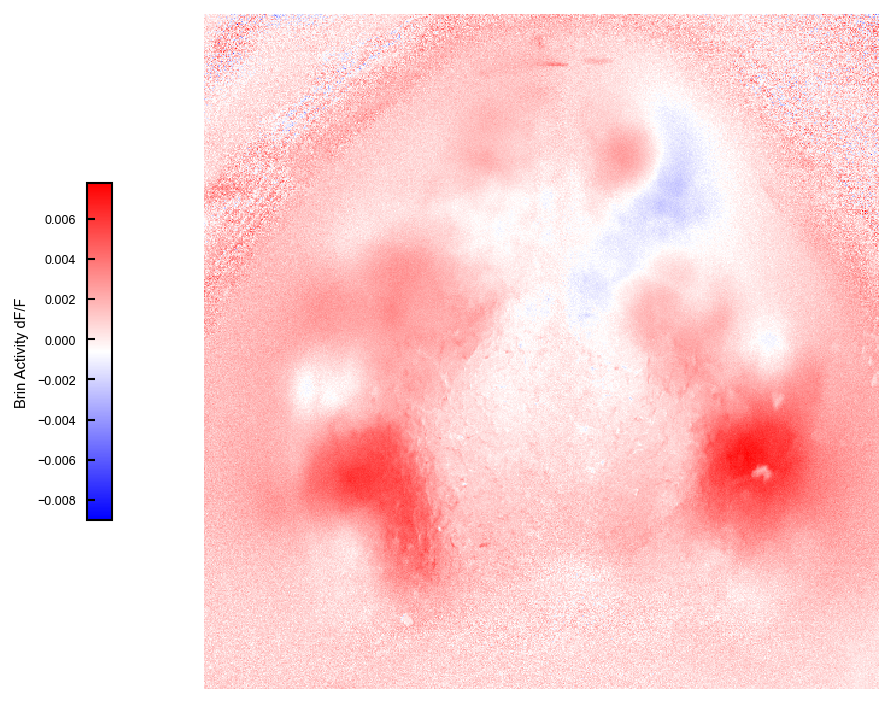

In [182]:
fig, ax = plt.subplots()
brainImg(ax,data=data822Vis,frame=100,galvoX=0,galvoY=0,n_samples=300,power=1.5)

In [183]:
fig.savefig('sfn figs/visbrain.pdf',dpi=300)

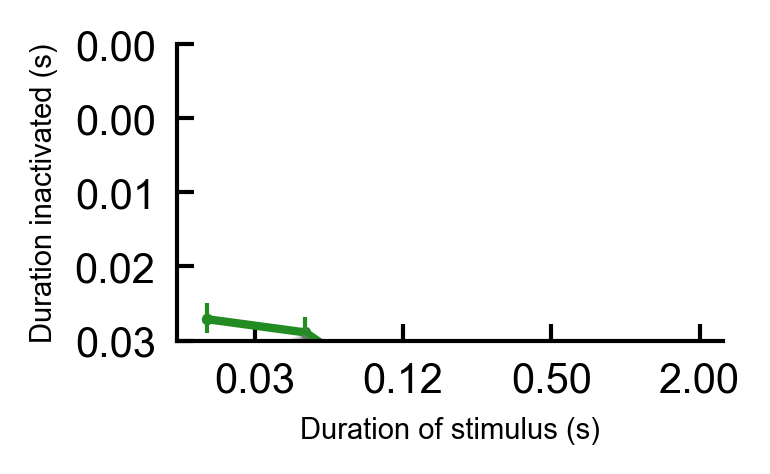

In [267]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
ax = plt.gca()

# wfTraceAvg(ax,dataList=[data425,data621,data729],ylim=[-0.09,0.08],\
#              galvoXList=[0,0,0],galvoYList=[3.3,4,4],powers=[0.2,1.7,3.2],cols=1,\
#                 x=170,y=400,n_samples=300,width=15,title='Response to increasing power')

# wfTrace(ax,data=data425,ylim=[-0.09,0.08],cols=1,\
#              galvoX=0,galvoY=3.3,powers=[0.2,1.7,3.2],\
#                 x=170,y=380,n_samples=300,width=15,title='Response at peak (90ms)')

# wfTrace(ax,data=data822,ylim=[-0.01,0.02],cols=1,ylabel='Calcium activity in V1',\
#              galvoX=0,galvoY=4,powers=[2.5],anchor=(0.4,1),fontsizelegend='medium',\
#                 x=120,y=400,n_samples=70,width=15,title='',stim=True,legend=False)
# x=220
# y=400
# respQuant(ax,data=data425,powers=np.unique(data425.laserPowers),ylim=[-0.09,0.05],galvoX=0,galvoY=3.3,x=x,y=y)
# respQuant(ax,data=data621,powers=np.unique(data621.laserPowers),ylim=[-0.09,0.05],galvoX=0,galvoY=4,color='grey',alpha=.3,x=x,y=y)
# respQuant(ax,data=data729,powers=np.unique(data729.laserPowers),ylim=[-0.09,0.05],galvoX=0,galvoY=4,color='grey',alpha=.3,x=x,y=y,title='Response at peak (90ms)')

# respQuantAvg(ax,dataList=[data425,data621,data729],ylim=[-0.06,0.03],\
#              galvoXList=[0,0,0],galvoYList=[3.3,4,4],\
#             n_samples=300,time=90,width=15,title='Response at peak (90ms)',\
#              powers=[0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2])

# stimLensOverlay(ax,data=data725,pow=1.7,x=350,y=400)
# plt.axvline(x=0.016)

# stimLensOverlayAvg(ax,dataList=[data],power=1.7,start=-.3,end=4,anchor=(1,0.5),ylim=[-0.05,0.03])
# x=[230,170,170]
# y=[420,400,400]
# inacTimeAvg(ax,dataList=[data725,data816,data822],xs=x,ys=y,title='Time inactivated by laser',pows=[1.7])

n_samples=100
inacTime(ax,data=data725,pow=1.7,y=400,x=350,n_samples=n_samples)
inacTime(ax,data=data816,pow=1.7,y=400,x=170,color='grey',alpha=.3,n_samples=n_samples)
inacTime(ax,data=data822,pow=1.7,y=400,x=170,color='grey',alpha=.3,n_samples=n_samples)

# spatQuant(ax,data=data425,x=170,y=400,xwidth=150,ywidth=70,\
#           galvoX=0,galvoY=3.3,n_samples=50)
# spatQuant(ax,data=data621,x=170,y=400,xwidth=150,ywidth=70,galvoX=0,galvoY=4,n_samples=50,color='grey',alpha=.3)
# spatQuant(ax,data=data729,x=170,y=400,xwidth=150,ywidth=70,galvoX=0,galvoY=4,n_samples=50,color='grey',alpha=.3)

# wfTrace(ax,data425,ylim=[-0.1,0.08],galvoX=0,galvoY=3.3,start=-.3,end=1,n_samples=650,powers=[.2,1.7,3.2],y=400,x=170,cols=1,anchor=(0.3,1))

# wfTrace(ax,data621,ylim=[-0.1,0.08],galvoX=0,galvoY=4,start=-.3,end=1,n_samples=650,powers=[.2,1.7,3.2],y=400,x=170,cols=1,anchor=(.3,1))

# wfTrace(ax,data822,ylim=[-0.02,0.03],galvoX=0,galvoY=4,start=-.3,end=1,n_samples=650,powers=[2.5],y=380,x=120)

# visRespCompare(ax,data=data822,ylim=[-0.01,0.03],exptrs=np.array([0,600,1200]),power=2.5,\
#                galvoX=0,galvoY=0,x=120,y=380,width=15,title="Stim with")

# visRespQuantCompare(ax,data=data822,ylim=[-0.01,0.03],exptrs=np.array([0,600,1200]),\
#                     time=190,galvoX=0,galvoY=0,x=120,y=380,width=15,ylabel=False)

# contralatPlot(ax,data=data621,galvoX=2,galvoY=4,start=-.3,end=1,\
#               n_samples=50,powerpick=0.7,width=15, info='Posterior Right',\
#                 anchor=(.8,1))

# pixls=[
#     [130,200],
#     [400,170]
# ]
# labels=['Left Ant','Left Post']

# contralatPlot(ax,data=data425,galvoX=0,galvoY=0,start=-.3,end=1,\
#               n_samples=75,powerpick=2,width=15, info='Anterior Left',\
#                 pixels=pixls,labels=labels,colors=['deepskyblue','darkviolet'])

In [247]:
f.savefig('sfn figs/aLpL.pdf',dpi=300)

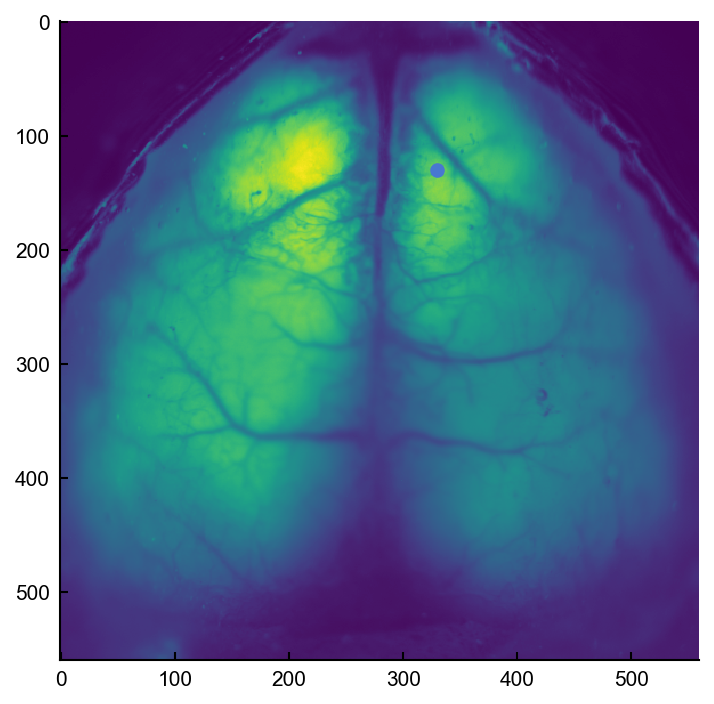

In [229]:
plt.imshow(data425.meanImage)
plt.scatter(x=330,y=130)

In [152]:
f.savefig('sfn figs/propinac.pdf',dpi=300)

## opto control

In [6]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    timeX = pixelInterp(time)

    return(timeX)

In [165]:
dataVis=data822Vis
dataOp=data425
powers5 = np.unique(dataVis.laserPowers)
vis,visem = powerQuantReturn(data=dataVis,powers=powers5,galvoX=0,galvoY=0,x=120,y=380,n_samples=650,time=220,width=15)
opto,optosem = powerQuantReturn(data=dataOp,powers=np.unique(dataOp.laserPowers),galvoX=0,galvoY=0,x=100,y=200,n_samples=650,time=90,width=15)
interp_func = scipy.interpolate.interp1d(powers5, vis, kind='linear', fill_value='extrapolate')
controlinterp = interp_func(np.unique(dataOp.laserPowers))
mice=[opto,controlinterp]

In [166]:
interp_sem = scipy.interpolate.interp1d(powers5,visem,kind='linear',fill_value='extrapolate')
controlinterpsem = interp_sem(np.unique(dataOp.laserPowers))
sem=[optosem,controlinterpsem]

(-0.09, 0.05)

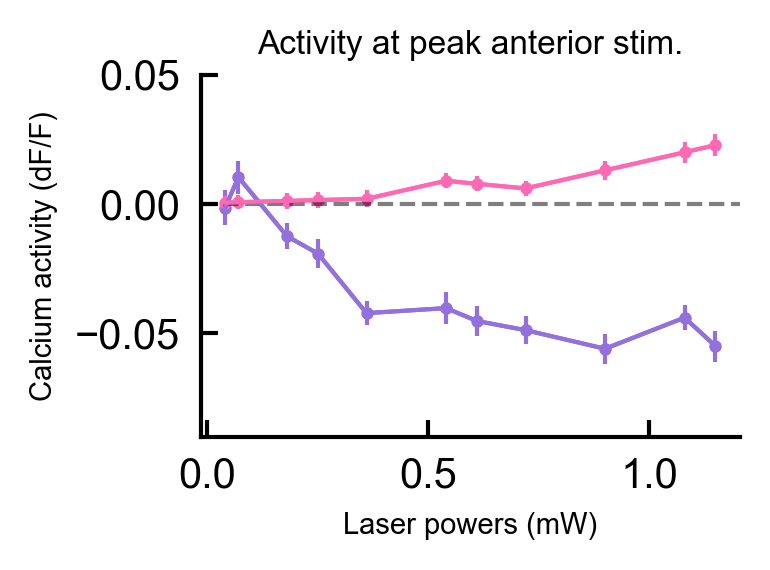

In [168]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers11=np.unique(dataOp.laserPowers)
powers = [round(i/2.777777778,2) for i in powers11]
colors=['mediumpurple','hotpink']
labels=['opto','control']

# lines = [plt.plot(powers, y, label=f'{labels[i]}',color=colors[i])[0] for i, y in enumerate(mice)]

for i,mouse in enumerate(mice):
    plt.plot(powers,mouse,'-o',c=colors[i],lw=1,markersize=2,label=labels[i])

    plt.errorbar(powers,mouse,yerr=sem[i],c=colors[i])

    plt.scatter(powers,mouse,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)
# plt.legend()
# legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
#                         columnspacing=0.5,handletextpad=0.3)

# # Change the color of the text in the legend to match the line colors
# for text, line in zip(legend.get_texts(), lines):
#     text.set_color(line.get_color())
# # Optionally, remove the lines and markers from the legend
# for legend_line in legend.get_lines():
#     legend_line.set_linewidth(0)
# for legend_marker in legend.get_patches():
#     legend_marker.set_visible(False)

plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel("Calcium activity (dF/F)",fontsize=7)
plt.title("Activity at peak anterior stim.",fontsize=8)
plt.axhline(y=0,color='black',linestyle='--',alpha=0.5)
plt.ylim(-0.09,0.05)

In [169]:
f.savefig('sfn figs/optocontrol.pdf',dpi=300)

### significance test 

significance test between each laser power (all trials raw) and 0
see which have significant p val - insignificant means you can stimulate reliably there
- in vis, it means theres a visresp
- in opto, it means that theres an inhibitory response

pseudo code
- find all trials for 0. this is your baseline
- find all trials for a subsquent value
- test agians thte baseline
- repeat for all laser powers

opto
- Power: 0.1 p-value: 1.0
- Power: 0.2 p-value: 0.7659314523482239
- Power: 0.5 p-value: 0.2656871402817289
- Power: 0.7 p-value: 0.9188052214121167
- Power: 1.0 p-value: 0.054141077480362725
- Power: 1.5 p-value: 0.006760732303569208
- Power: 1.7 p-value: 0.003018184077228396
- Power: 2.0 p-value: 0.01430154804770646
- Power: 2.5 p-value: 0.00018791118070078278
- Power: 3.0 p-value: 0.0012708143485281624
- Power: 3.2 p-value: 0.00018791118070078278

vis
- Power: 0.5 p-value: 1.0
- Power: 1.0 p-value: 0.9900193288833089
- Power: 1.5 p-value: 0.16497269950224194
- Power: 2.0 p-value: 0.09707484379785862
- Power: 2.5 p-value: 0.0628915213997205

find the baseline val just so we have it, then we can loop through the rest

In [201]:
data=data822Vis
n_samples=650
time=90
x=120
y=380
width=15
galvoX=0
galvoY=0
power=.5
tr1 = 600
tr2 = 1200

timestamps = np.linspace(-0.3, 1, n_samples)*1000
pxPowers = []
sems=[]

meanimg = data.meanImage.reshape(560,560,-1)
avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
        
galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
loc=np.intersect1d(galvoXTrs,galvoYTrs)

pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
theseTrs=np.intersect1d(pwTrs,loc)
onTimes = data.laserOn[theseTrs]
trs = [np.linspace(-.2+on, -.1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

trial_activity=[]
baseline_peaks=[]
for trial in trs:
    wf = data.tToWFManual(trial)
    mov = data.svdSpat[flat_indices] @ wf.T
    videoROI_avg = np.mean(mov,axis=0)
    dff = videoROI_avg/avg
    pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
    baseline_peaks.append(pixelInterpTrial(time))

loop through the rest and save the p vals

In [202]:
galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
loc=np.intersect1d(galvoXTrs,galvoYTrs)
time=220
for iP, power in enumerate(np.unique(data822Vis.laserPowers)):
    pwTrs = np.argwhere(data822Vis.laserPowers[tr1:tr2] == power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    trial_activity=[]
    trial_peaks=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
        trial_peaks.append(pixelInterpTrial(time))
    res = scipy.stats.ks_2samp(baseline_peaks,trial_peaks)
    print(f'Power: {power} p-value: {res.pvalue}')

Power: 0.5 p-value: 0.5786001416508443
Power: 1.0 p-value: 0.404587405685253
Power: 1.5 p-value: 0.01430154804770646
Power: 2.0 p-value: 0.02860307028023343
Power: 2.5 p-value: 0.00876361567496048


In [65]:
1/2.777778

0.35999997120000227

## test brain

(-0.5, 559.5, 559.5, -0.5)

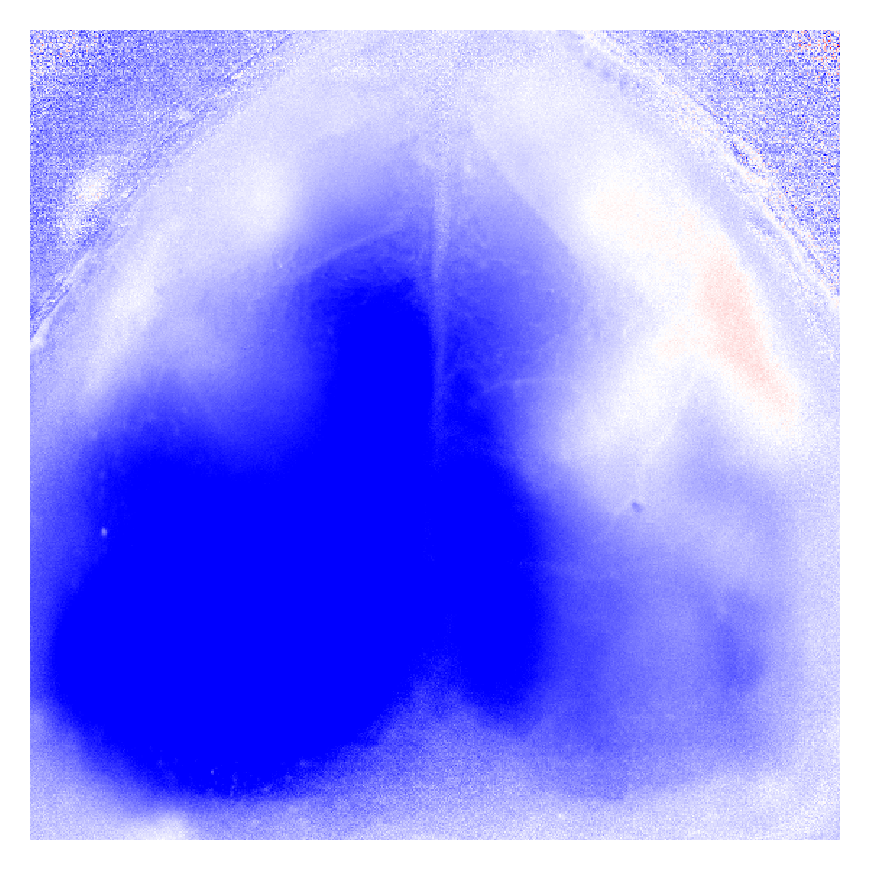

In [90]:
data=data425
power=2
galvoX=0
galvoY=3.3
start=-.3
end=1
n_samples=50
frame=16
title=""
normset=0

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

#using normalize
# vmin, vmax = np.percentile(mov_mean_dff[:, :, frame], [2, 98])
# if normset == 0:
#     normset = Normalize(vmin=-1.5*max(abs(vmin), vmax), vmax=1.5*max(abs(vmin), vmax))
# plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', norm=normset,interpolation='none')

#using clim
pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
fig = plt.figure(figsize=(4, 3), dpi=300)
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none')
# gs = mpl.gridspec.GridSpec(5,10)
# for i in range(50):
#     ax = fig.add_subplot(gs[i])
#     ax.imshow(mov_mean_dff[:,:,i], cmap='bwr', clim=clim,interpolation='none')
#     ax.axis('off')

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.axis('off')
# cbar = plt.colorbar(shrink=0.5,aspect=13)
# cbar.ax.tick_params(labelsize=6)


In [89]:
fig.savefig('sfn figs/pow3.pdf',dpi=300)

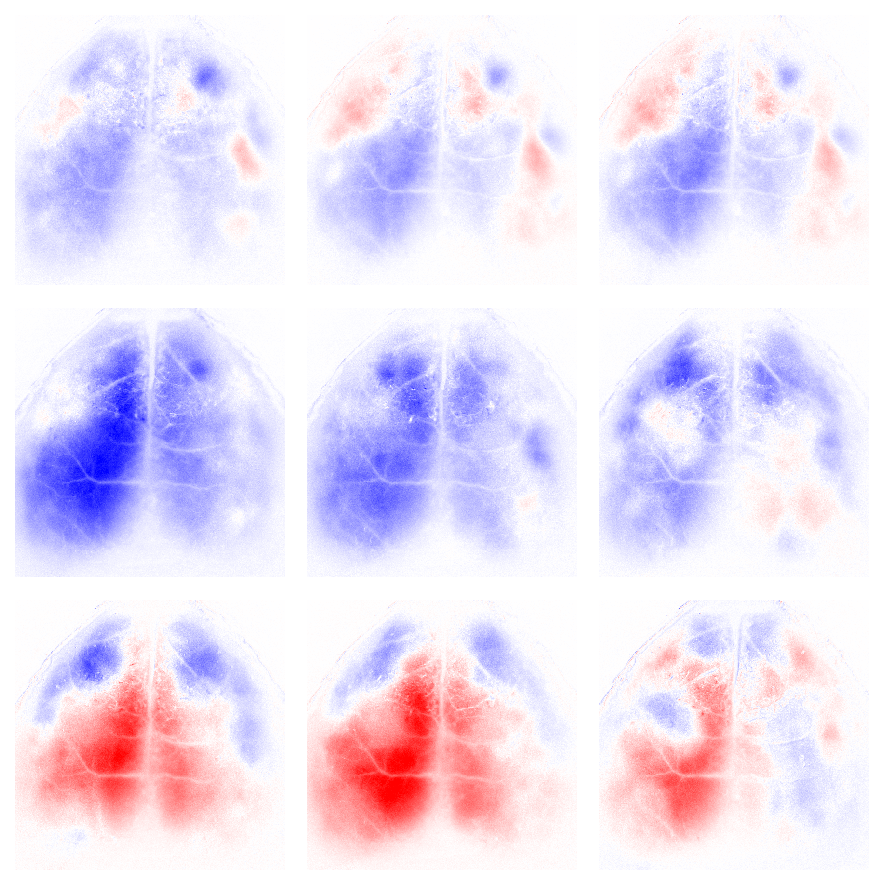

In [34]:
pows = np.argwhere(data425.laserPowers==1).ravel()
galvoY=np.argwhere(data425.galvoY==3.3)
galvoX=np.argwhere(data425.galvoX==0)
loc=np.intersect1d(galvoX,galvoY)
theseTrs=np.intersect1d(loc,pows)

allVideos=[]
for trial in theseTrs:
    startTime = data425.laserOn[data425.listExps[0][trial]]
    endTime = data425.laserOn[data425.listExps[0][trial]] + .5
    
    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = data425.tToWf(trial_time)
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)

    videoAvg = data425.spatial @ dwf
    videoAvg = videoAvg.reshape(560,560,-1)
    acrossTrials=np.mean(videoAvg,axis=0)

    allVideos.append(acrossTrials)

allVideos = np.array(allVideos)
clim=np.percentile(videoAvg,(0,100))
true_colorbar=clim
n_cols = 3
n_rows = 3
f = plt.figure(figsize=(n_cols*2, n_rows*2))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(n_cols*n_rows):
    ax = plt.subplot(gs[i])
    plt.imshow(videoAvg[:, :,i*5+1],clim = true_colorbar, cmap='bwr',vmax=100,vmin=-100)
    #plt.colorbar()
    plt.axis('off')

f.tight_layout()

## graveyaard

In [ ]:
def wfTrace(ax,data,powers,galvoX,galvoY,y,x,width=15,n_samples=650,\
            start=-.3,end=1,xlim=[-300,600],\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=2,\
            ylabel=True,fontsizelegend='xx-small',seclabel='ms'):
    '''
    traces of activity in response to different powers for one location in one dataset
        data = what dataset
        powrs = list of powers to plot activity for
        galvoX = X location
        galvoY = Y location
        y = y pixel to center ROI around
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    if len(powers)<=3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.Blues(np.linspace(.3,1,lenpows))
    pxPowers = []
    sems=[]
    timestamps = np.linspace(start, end, n_samples)*1000
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        trace=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(trace)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxPowers,axis=0),\
                power+scipy.stats.sem(pxPowers,axis=0), color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                        columnspacing=0.5,handletextpad=0.3)
    
    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.xlabel(f'Time {seclabel}',fontsize=10)
    if ylabel:
        plt.ylabel('Brain Activity df/f',fontsize=10)
    plt.title(f'{title}')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)


inactime new draft

<ErrorbarContainer object of 3 artists>

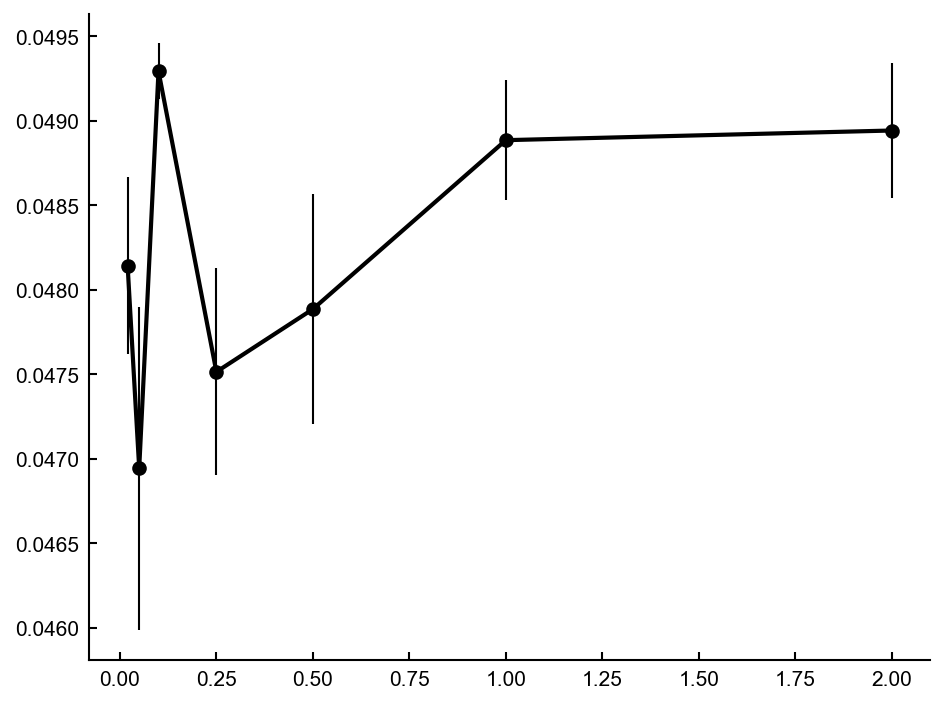

In [97]:
data=data816
n_samples=50
x=120
y=380
width=15
power=1.7

meanimg = data.meanImage.reshape(560,560,-1)
avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

#getting presets for null pts
pws = np.argwhere(data.laserPowers == power).ravel()
onTimes = data.laserOn[pws]
trs_baseline = [np.linspace(-.3+on, -.2+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs_baseline))

#getting null pts
trial_activity=[]
baselines=[]
for trial in trs:
    wf = data.tToWFManual(trial)
    mov = data.svdSpat[flat_indices] @ wf.T
    videoROI_avg = np.mean(mov,axis=0)
    dff = videoROI_avg/avg
    baselines.append(np.mean(dff,axis=0))
std = np.std(baselines)
threshold = std*2

#now finding time spent below threshold
pxLens = []
sems=[]
for iL,len in enumerate(np.unique(data.pulseLengths)):
    lens = np.argwhere(data.pulseLengths == len).ravel()
    theseTrs = np.intersect1d(pws,lens)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    pxTrs=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        tf = [i < threshold for i in dff]
        deac = dff[tf]
        pxTrs.append(deac.shape[0] * (1 / 1000))
    sems.append(scipy.stats.sem(pxTrs))
    pxLens.append(np.mean(pxTrs,axis=0))
plt.plot(np.unique(data.pulseLengths),pxLens,'-o',c='k',lw=2)
plt.errorbar(np.unique(data.pulseLengths),pxLens,yerr=sems,c='k')
